# Polynomial Regression, Overfitting and Regularisation

Import necessary modules:

In [1]:
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats
from scipy.special import gamma
import preliz as pz
import matplotlib as mpl
import pymc as pm
import bambi as bmb

In [2]:
plt.style.use('ggplot')
plt.rcParams["figure.figsize"] = (12,3)

## Create small sample

<Axes: xlabel='BMI', ylabel='BodyFat'>

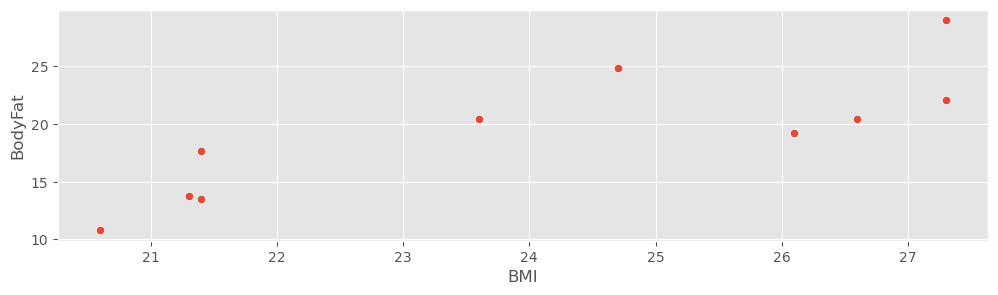

In [3]:
data = pd.read_csv("bodyfat.csv")
data_simple = data[data.BMI<35] # remove outliers to avoid using a robust model
data_10points = data_simple.sample(10, random_state=3)
sns.scatterplot( data=data_10points, x="BMI", y="BodyFat" )

## Fit a linear model

In [4]:
linear_model = bmb.Model("BodyFat ~ BMI", data_10points, family="gaussian")
linear_trace = linear_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


## Fit a polynomial model

In [5]:
poly_model = bmb.Model("BodyFat ~ BMI + I(BMI**2) + I(BMI**3)", data_10points, family="gaussian")
poly_trace = poly_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI, I(BMI ** 2), I(BMI ** 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 11 seconds.
There were 177 divergences after tuning. Increase `target_accept` or reparameterize.


Slow and full of divergences! Better use orthogonal polynoms using the `poly()` function:

In [6]:
poly_model = bmb.Model("BodyFat ~ poly( BMI, 3 )", data_10points, family="gaussian")
poly_trace = poly_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(BMI, 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


## Compare models

Default computed for conditional variable: BMI
Default computed for conditional variable: BMI


Text(0.5, 1.0, 'BodyFat ~ poly(BMI, 3)')

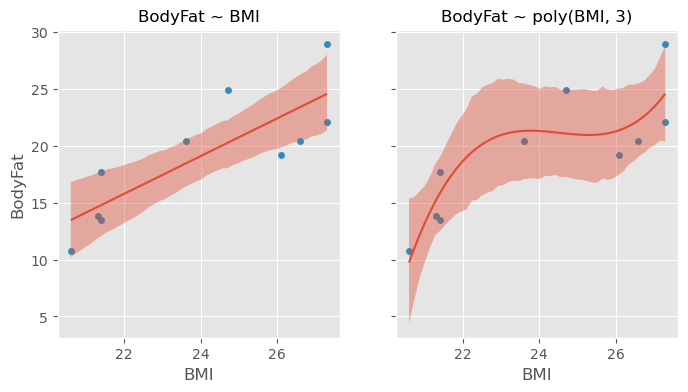

In [7]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8,4) )
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[0] )
bmb.interpret.plot_predictions( linear_model, linear_trace, "BMI", prob=0.9, ax=ax[0] )
ax[0].set_title("BodyFat ~ BMI", fontsize=12)
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[1] )
bmb.interpret.plot_predictions( poly_model, poly_trace, "BMI", prob=0.9, ax=ax[1] )
ax[1].set_title("BodyFat ~ poly(BMI, 3)", fontsize=12)

The polynomial model is clearly overfitting to the noise in the data points.

## Regularisation

Look at the model:

In [8]:
poly_model

       Formula: BodyFat ~ poly( BMI, 3 )
        Family: gaussian
          Link: mu = identity
  Observations: 10
        Priors: 
    target = mu
        Common-level effects
            Intercept ~ Normal(mu: 19.18, sigma: 13.0928)
            poly(BMI, 3) ~ Normal(mu: [0. 0. 0.], sigma: [41.4032 41.4032 41.4032])
        
        Auxiliary parameters
            sigma ~ HalfStudentT(nu: 4.0, sigma: 5.2371)
------
* To see a plot of the priors call the .plot_priors() method.
* To see a summary or plot of the posterior pass the object returned by .fit() to az.summary() or az.plot_trace()

Weak priors used for all coefficients! Instead shrink the higher order coefficients towards zero with stronger priors:

In [9]:
priors = {
    "poly(BMI, 3)": bmb.Prior("Normal", mu=[0,0,0], sigma=[41.4,1,1]),
}

poly_model2 = bmb.Model("BodyFat ~ poly(BMI, 3)", data_10points, priors=priors, family="gaussian")
poly_trace2 = poly_model2.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, poly(BMI, 3)]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


Default computed for conditional variable: BMI
Default computed for conditional variable: BMI


Text(0.5, 1.0, '$\\sigma$ = [41.4, 1, 1] (strong)')

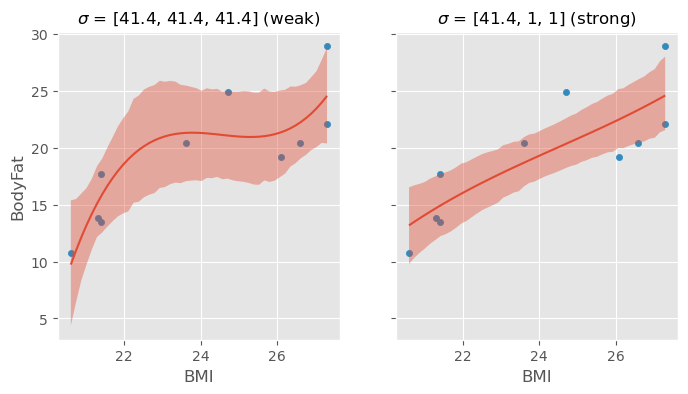

In [10]:
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(8,4) )
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[0] )
bmb.interpret.plot_predictions( poly_model, poly_trace, "BMI", prob=0.9, ax=ax[0] )
ax[0].set_title("$\sigma$ = [41.4, 41.4, 41.4] (weak)", fontsize=12)
data_10points.plot.scatter( x="BMI", y="BodyFat", ax=ax[1] )
bmb.interpret.plot_predictions( poly_model2, poly_trace2, "BMI", prob=0.9, ax=ax[1] )
ax[1].set_title("$\sigma$ = [41.4, 1, 1] (strong)", fontsize=12)

The model with stronger priors is almost linear!

## Model Selection

Model selection should also help us to choose the best polynomial degree!

### Marginal Likelihood

We would expect here that the marginal likelihood is lower for more complex model. Bambi does not have a native option yet to use SMC for training (to get the log marginal likelihood), but we can easily achieve this by accessing the backend:

In [11]:
def fit_with_smc( bambi_model, **kwargs ):
    bambi_model.build()
    with bambi_model.backend.model:
        trace = pm.sample_smc( **kwargs )
    return trace

Fit all the models with SMC:

In [12]:
linear_model = bmb.Model("BodyFat ~ BMI", data_10points, family="gaussian")
linear_trace = fit_with_smc( linear_model, draws=2000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [13]:
quadratic_model = bmb.Model("BodyFat ~ poly(BMI, 2)", data_10points, family="gaussian")
quadratic_trace = fit_with_smc( quadratic_model, draws=2000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

In [14]:
cubic_model = bmb.Model("BodyFat ~ poly(BMI, 3)", data_10points, family="gaussian")
cubic_trace = fit_with_smc( cubic_model, draws=2000, chains=4 )

Initializing SMC sampler...
Sampling 4 chains in 4 jobs


Output()

Extract marginal likelihoods:

In [15]:
log_ml_linear = linear_trace.sample_stats.log_marginal_likelihood.mean()
log_ml_quadratic = quadratic_trace.sample_stats.log_marginal_likelihood.mean()
log_ml_cubic = cubic_trace.sample_stats.log_marginal_likelihood.mean()
log_ml_linear.values, log_ml_quadratic.values, log_ml_cubic.values

(array(-33.98044302), array(-33.91725078), array(-35.7118078))

Bayes factors:

In [16]:
BF_quadratic_linear = np.exp( log_ml_quadratic - log_ml_linear )
BF_quadratic_linear.values

array(1.0652316)

In [17]:
BF_cubic_linear = np.exp( log_ml_cubic - log_ml_linear )
BF_cubic_linear.values

array(0.17704262)

In [18]:
BF_cubic_quadratic = np.exp( log_ml_cubic - log_ml_quadratic )
BF_cubic_quadratic.values

array(0.16620106)

No model is convincingly better than the linear model! The Bayes factor is slightly in favor of the quadratic model, but not in a decisive way, keep the simplest model!

### ELPD

Compute ELPD for linear model:

In [19]:
linear_model = bmb.Model("BodyFat ~ BMI", data_10points, priors=priors, family="gaussian")
linear_trace = linear_model.fit(draws=2000, tune=2000)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, Intercept, BMI]


Output()

Sampling 4 chains for 2_000 tune and 2_000 draw iterations (8_000 + 8_000 draws total) took 3 seconds.


In [20]:
with linear_model.backend.model:
    pm.compute_log_likelihood(linear_trace)
loo_linear = pm.loo( linear_trace )

Output()

/home/chuwyler/miniconda3/envs/bayesian-machine-learning/lib/python3.11/site-packages/arviz/stats/stats.py:797: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.70 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  warnings.warn(


The PSIS approximation breaks down for a low number of samples. Our principal reason to use PSIS was that in leave-one-out CV we would have to run n MCMC simulations (might be very expensive!). We stop here, but in principal we could now run our own 10 MCMCs and visualize the resulting log likelihoods.